# Object detection lab

Understand the intuition behind object detection here:

- http://vision.stanford.edu/teaching/cs231b_spring1415/slides/ssearch_schuyler.pdf


- [A Step-by-Step Introduction to the Basic Object Detection Algorithms (Part 1)](https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/)
- [A Practical Implementation of the Faster R-CNN Algorithm for Object Detection (Part 2 – with Python codes)
](https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/)
- [A Practical Guide to Object Detection using the Popular YOLO Framework – Part III (with Python codes)](https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/)

In [1]:
from libraries import detection
import matplotlib.pyplot as plt
import numpy as np
import mlutils
%matplotlib inline
from matplotlib.patches import Rectangle 
from skimage.transform import resize

In [2]:
def show_boxes(img, boxes):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    ax.imshow(img)
    for i in range(len(boxes)):
        b = boxes[i]
        w,h = b[2]-b[0], b[3]-b[1]
        if w*h<100:
            continue
        rect = Rectangle((b[0],b[1]), w, h, linewidth=2, edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    

## Running selective seearch

observe how selective search computes a set of suggested boxes possibly containing objects.

inspect the contents of the numpy array with the selected boxes.

/home/gabriel24/anaconda3/envs/python2/lib/python2.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/gabriel24/anaconda3/envs/python2/lib/python2.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]


. . . . (40, 4)


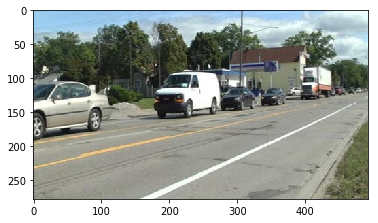

In [3]:
img = plt.imread("Images/cars-driving.jpg")
bb = detection.selective_search(img, ks=[700])
print (bb.shape)
plt.imshow(img)

In [4]:
bb[0]

array([  0.,   0., 492., 277.])

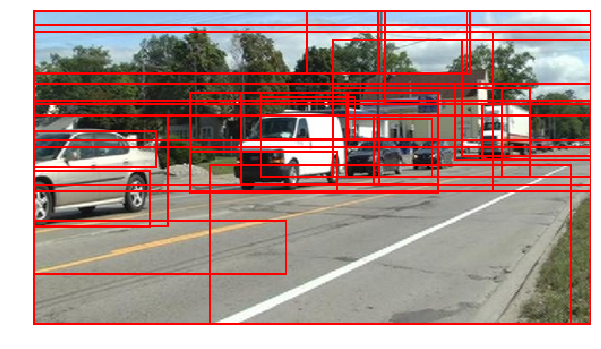

In [5]:
show_boxes(img, bb)

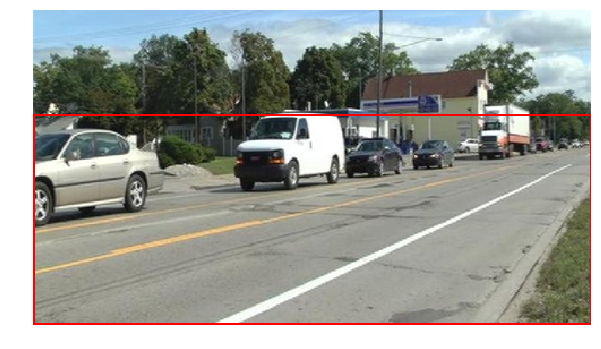

In [6]:
show_boxes(img, bb[1:2])

## Part 1: Run pretrained alexnet finetuned model on patches

- load the alexnet finetuned model obtained in the Transfer Learning notes
- for each box extract a patch from the image
- resize all patches, use [skimage.transform.resize](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize)
- run the model
- select the patches with class **car**
- show all boxes with car detections
- do not include patches with small areas (less than 100 px^2)

To run the model your are suggested to:

- first gather all resized patches in a single array
- call only once `model.predict`

Observe that the `predict` function on the model will yield the class probabilities. Simply select the class with highest proabability on each image.

You may get something like the following image, with the **car** patches overimposed. You result might differ.

![](./Images/lab_dectection_02.png)

In [7]:
## load model

from tensorflow.keras.models import load_model

model = load_model("alexnet_finetuned_minicifar.model")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


make list of patches from selective search boxes

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
__________

#### Recortamos los bounding boxes obtenidos en la busqueda selectiva

In [9]:
rpatches = []
for i in (range(len(bb))):
    rpatches.append(img[int(bb[i][1]):int(bb[i][3]),int(bb[i][0]):int(bb[i][2])])


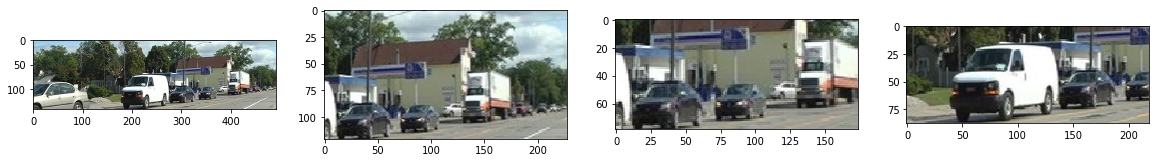

In [10]:
plt.figure(figsize=(20,10))
for i in range(1,5):   
    plt.subplot(1,4,i)    
    plt.imshow(rpatches[i+4])

### Resize al tamaño de entrada de la red.

In [11]:
from skimage.transform import resize
patches=[resize(i,(32,32)) for i in rpatches]

/home/gabriel24/anaconda3/envs/python2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/gabriel24/anaconda3/envs/python2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


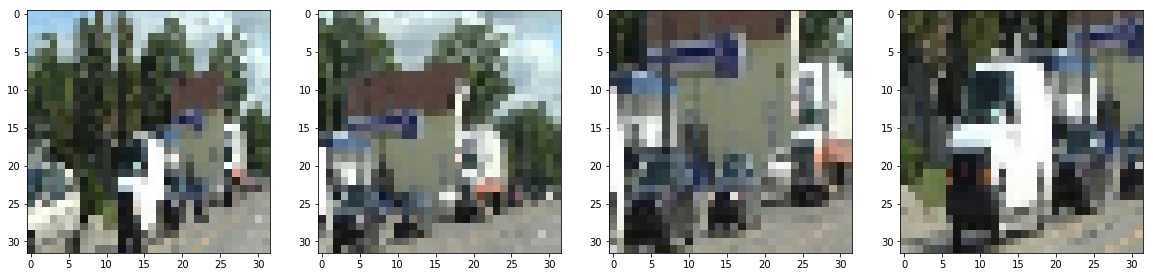

In [12]:
plt.figure(figsize=(20,10))
for i in range(1,5):   
    plt.subplot(1,4,i)    
    plt.imshow(patches[i+4])

In [13]:
rboxes = np.r_[patches]
rboxes.shape

(40, 32, 32, 3)

get the model class predictions (you will get probabilities and need to transform them to classes)

In [14]:
bpreds = model.predict(rboxes)

In [15]:
bpreds[:10]

array([[2.6707920e-01, 1.0445982e-03, 7.3187619e-01],
       [7.0286232e-01, 2.7689084e-01, 2.0246763e-02],
       [3.2926643e-01, 5.0277454e-03, 6.6570580e-01],
       [4.1712062e-03, 9.9476409e-01, 1.0646973e-03],
       [2.7471513e-01, 6.6161090e-01, 6.3673906e-02],
       [2.6313533e-06, 9.9999487e-01, 2.5131496e-06],
       [5.3500408e-01, 4.2027825e-01, 4.4717602e-02],
       [1.2975149e-02, 9.7740209e-01, 9.6227173e-03],
       [1.1262330e-03, 9.9413991e-01, 4.7339369e-03],
       [7.0130324e-01, 4.4482714e-04, 2.9825190e-01]], dtype=float32)

In [16]:
preds=[bpreds[i].argmax() for i in range(0,len(bpreds))]
preds[:10]


[2, 0, 2, 1, 1, 1, 0, 1, 1, 0]

### Ubicamos los bounding boxes clasificados con carros.

In [17]:
bbp=list(np.where(list(np.array(preds)==1)))

select the predictions with cars

In [18]:
bcars = bb[bbp]
bcars.shape

/home/gabriel24/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


(13, 4)

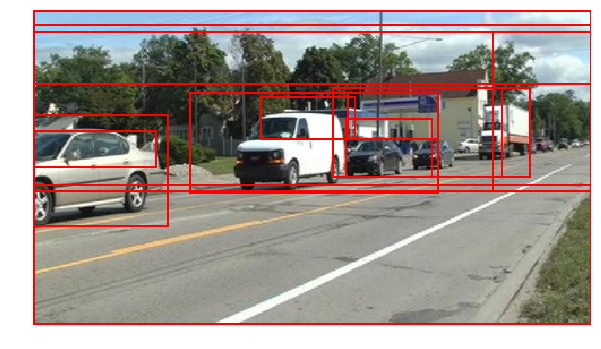

In [19]:
show_boxes(img, bcars)

## Part 2: Devise some strategy to filter and merge patches

- remove patches that intersect with many (likely to be too large)
- remove patches that intersect with too few (objects are likely to produce several patches)
- merge patches that overlap more than 50% of any of the two
- any other strategy you might devise

Observe that your result **will not be perfect**. This is OK, since we are using a classifier trained with a small dataset.

This is a possible outcome

![](./Images/lab_dectection_01.png)

## Vamos a escojer los bounding box con una longitud menor a 130

In [20]:
idxbcars=[(bcars[i][3]-bcars[i][1])<130 for i in range(len(bcars))]
idxbcars

[False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True]

In [21]:
sbcars = bcars[idxbcars]
len(sbcars)

8

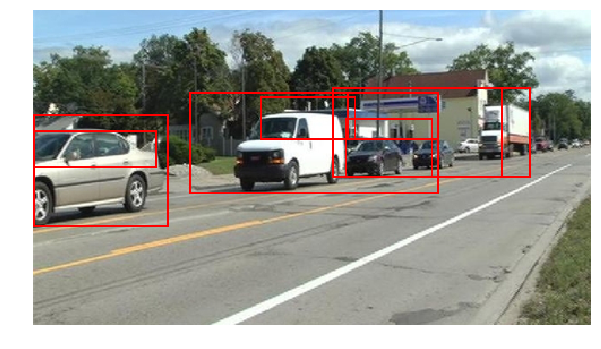

In [22]:
show_boxes(img, sbcars)

## Ahora vamos a hacer una metrica que me indique el porcentaje de veces que un bounding box esta dentro de otro.

In [23]:
idxcars2=[(((sbcars[i][1]>=sbcars[j][1])&(sbcars[i][3]<=sbcars[j][3]))&((sbcars[i][0]>=sbcars[j][0])&(sbcars[i][2]<=sbcars[j][2])) )for i in range(0,len(sbcars)) for j in range(0,len(sbcars))]
len(idxcars2)

64

In [24]:
c=0
for i in range(0,len(sbcars)):
    for j in range(0,len(sbcars)):
        pass
        
        


In [25]:
idxcars2[0:8]

[True, False, False, False, False, False, False, False]

In [26]:
range(1,len(idxcars2),8)

[1, 9, 17, 25, 33, 41, 49, 57]

In [27]:
idxcars3=[np.array(idxcars2[i:8+i]).mean() for i in range(1,len(idxcars2),8)]
idxcars3
#Porcentaje de veces que el box se encontro dentro de otros.

[0.0, 0.125, 0.25, 0.125, 0.375, 0.375, 0.375, 0.42857142857142855]

### Escojemos los bounding boxes que se encontraron un menor numero de veces completamente dentro de otros.

In [28]:
idxb3=[i==0 for i in idxcars3]

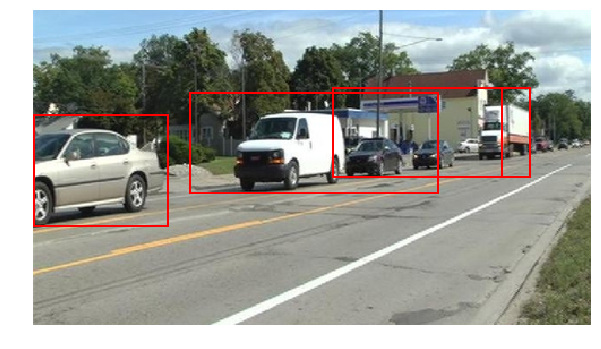

In [29]:
sbcars2 = sbcars[[i<=0.25 for i in idxcars3]]
show_boxes(img, sbcars2)